# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# **Load the Dataset**

In [ ]:
# Load the dataset
file_path = '/content/owid-covid-data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [ ]:
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

# **Data Preprocessing**

In [ ]:
# Aggregate data globally
global_data = data.groupby('date')['total_cases'].sum().reset_index()

# Convert date column to datetime
global_data['date'] = pd.to_datetime(global_data['date'], errors='coerce')

# Set the date column as the index
global_data.set_index('date', inplace=True)

# Fill missing values with interpolation
global_data = global_data.interpolate()

# Create time series features
look_back = 7
X, y = [], []

for i in range(len(global_data) - look_back):
    X.append(global_data.iloc[i:i + look_back]['total_cases'].values)
    y.append(global_data.iloc[i + look_back]['total_cases'])

X, y = np.array(X), np.array(y)

## **Split the data into training and testing**

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Implement the Random Forest Model and Optimization**

In [ ]:
# Initialize the Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Optimize the model using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


# **Model Evaluation**

In [ ]:
# Predict the test set results
predictions = best_model.predict(X_test)

# Calculate the accuracy metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 28170851542263.547
Mean Absolute Error: 840708.9579293698
R-squared: 0.9985583183629761


# **Data Augmentation**

In [ ]:
# Adding rolling statistics
global_data['rolling_mean_7'] = global_data['total_cases'].rolling(window=7).mean().shift(1)
global_data['rolling_std_7'] = global_data['total_cases'].rolling(window=7).std().shift(1)

# Drop rows with NaN values created by the rolling statistics
global_data = global_data.dropna()

# Create features including rolling statistics
X_aug, y_aug = [], []
for i in range(len(global_data) - look_back):
    features = global_data.iloc[i:i + look_back][['total_cases', 'rolling_mean_7', 'rolling_std_7']].values.flatten()
    X_aug.append(features)
    y_aug.append(global_data.iloc[i + look_back]['total_cases'])

X_aug, y_aug = np.array(X_aug), np.array(y_aug)

# Split the augmented data into training and testing sets
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

# **Model Training and Prediction for Future Cases**

In [ ]:
# Train the model with augmented data
best_model.fit(X_train_aug, y_train_aug)

# Predict the test set results with augmented data
predictions_aug = best_model.predict(X_test_aug)

# Ensure that last_known_values is a DataFrame with correct column names
feature_names = ['total_cases', 'rolling_mean_7', 'rolling_std_7']
last_known_values = global_data[feature_names].iloc[-look_back:].values.flatten()
future_predictions = []

for _ in range(30):
    current_features = last_known_values.reshape(1, -1)
    next_pred = best_model.predict(current_features)[0]
    future_predictions.append(next_pred)
    last_known_values = np.roll(last_known_values, -3)
    last_known_values[-3:] = [next_pred, np.mean(future_predictions[-look_back:]), np.std(future_predictions[-look_back:])]

future_dates = pd.date_range(start=global_data.index[-1] + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Confirmed': future_predictions})

# **Visualization**

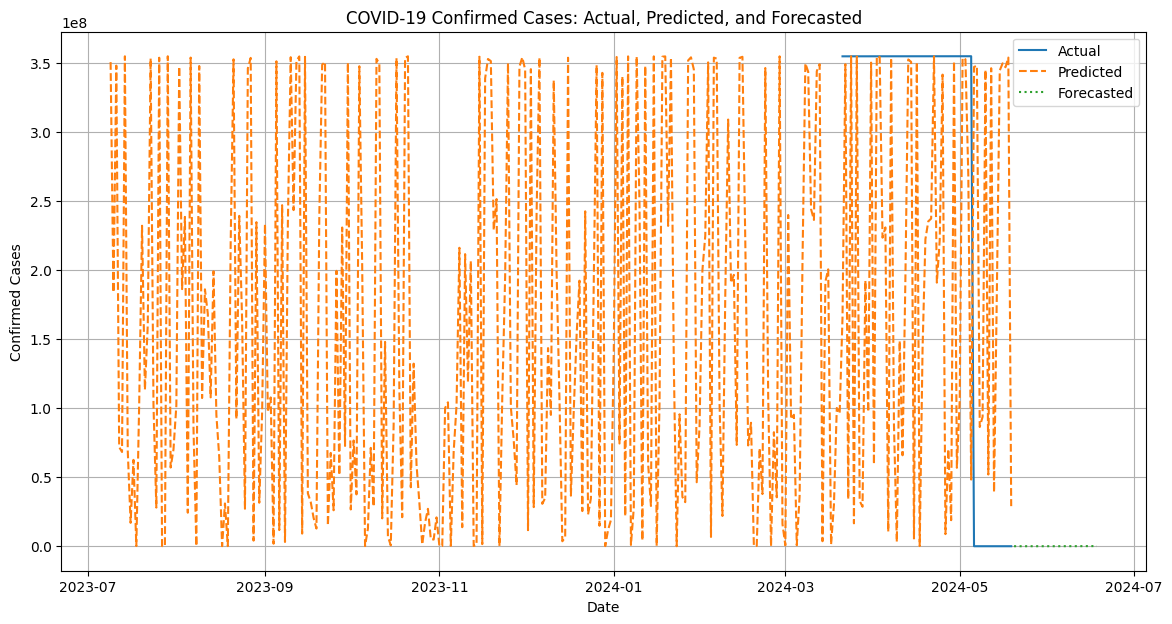

In [28]:
plt.figure(figsize=(14, 7))

# Adjust the length of y_test and predictions_aug to match
adjusted_length = min(len(global_data.index[-len(y_test):]), len(predictions_aug))

plt.plot(global_data.index[-60:], global_data['total_cases'][-60:], label='Actual')
plt.plot(global_data.index[-adjusted_length:], predictions_aug[:adjusted_length], label='Predicted', linestyle='--')
plt.plot(future_df['Date'], future_df['Predicted_Confirmed'], label='Forecasted', linestyle=':')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases: Actual, Predicted, and Forecasted')
plt.legend()
plt.grid(True)
plt.show()

**Display best model parameters**

In [29]:
print("Best model parameters:", grid_search.best_params_)

Best model parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
